# Reconnaissance d’espèces de poissons dans des images sous-marines
# Classification avec CNN (TensorFlow / Keras)

## Importation des Librairies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-05-27 15:41:08.729603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748360469.198438      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748360469.322963      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Paramètres globaux

In [2]:
image_size = (224, 224)
batch_size = 32
base_dir = "/kaggle/input/fish-dataset/FishImgDataset"

## Definition de l'Architecture de CNN

In [3]:
def create_simple_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Générateurs de données

In [4]:
def prepare_data_generators(base_dir, image_size, batch_size):
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "val")
    test_dir = os.path.join(base_dir, "test")

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1]
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical'
    )
    val_generator = val_test_datagen.flow_from_directory(
        val_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical'
    )
    test_generator = val_test_datagen.flow_from_directory(
        test_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=False
    )

    print(f"\nClasses: {train_generator.class_indices}")
    return train_generator, val_generator, test_generator

## Échantillon d’images du jeu d'entraînement

In [5]:
# images, labels = next(train_generator)

# # Afficher 9 images avec leurs labels
# plt.figure(figsize=(10, 10))
# class_names = list(train_generator.class_indices.keys())

# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i])
#     label_index = np.argmax(labels[i])
#     plt.title(f"Classe : {class_names[label_index]}")
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

# Former et évaluer le modèle

In [6]:
def train_and_evaluate_model(model, train_generator, val_generator, test_generator, epochs=30):
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ModelCheckpoint('best_fish_cnn_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    ]
    
    history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks)
    
    val_loss, val_acc = model.evaluate(val_generator)
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\nValidation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes[:len(y_pred)]
    
    class_names = list(test_generator.class_indices.keys())
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualizations avec des graphiques beaucoup plus grands
    
    # 1. Graphique des Accuracy - Plus grand et séparé
    plt.figure(figsize=(15, 8))
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=3, marker='o', markersize=6)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=3, marker='s', markersize=6)
    plt.title("Accuracy over Epochs", fontsize=20, fontweight='bold', pad=20)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # 2. Graphique des Loss - Plus grand et séparé
    plt.figure(figsize=(15, 8))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3, marker='o', markersize=6, color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=3, marker='s', markersize=6, color='orange')
    plt.title("Loss over Epochs", fontsize=20, fontweight='bold', pad=20)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # 3. Matrice de confusion - Beaucoup plus grande
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={'size': 14}, cbar_kws={'shrink': 0.8})
    plt.title("Confusion Matrix", fontsize=20, fontweight='bold', pad=20)
    plt.xlabel("Predicted", fontsize=16)
    plt.ylabel("Actual", fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()
    plt.show()
    
    # 4. Graphique combiné optionnel - Vue d'ensemble
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s')
    ax1.set_title("Accuracy over Epochs", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Accuracy", fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o', color='red')
    ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2, marker='s', color='orange')
    ax2.set_title("Loss over Epochs", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Loss", fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=ax3, annot_kws={'size': 10})
    ax3.set_title("Confusion Matrix", fontsize=16, fontweight='bold')
    ax3.set_xlabel("Predicted", fontsize=12)
    ax3.set_ylabel("Actual", fontsize=12)
    
    # Métriques de performance
    ax4.axis('off')
    metrics_text = f"""
    RÉSULTATS FINAUX
    
    Validation Accuracy: {val_acc:.4f}
    Test Accuracy: {test_acc:.4f}
    Validation Loss: {val_loss:.4f}
    Test Loss: {test_loss:.4f}
    
    Nombre d'époques: {len(history.history['accuracy'])}
    Nombre de classes: {len(class_names)}
    """
    ax4.text(0.1, 0.5, metrics_text, fontsize=14, verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Enregistrement final du modèle complet
    model.save("modele_final.h5")
    print("\nModèle final enregistré sous le nom 'modele_final.h5'")
    
    return history, test_acc

## Bloc d'exécution

In [7]:
train_generator, val_generator, test_generator = prepare_data_generators(base_dir, image_size, batch_size)

num_classes = len(train_generator.class_indices)
input_shape = image_size + (3,)
model = create_simple_cnn(input_shape, num_classes)

model.summary()

Found 8791 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.

Classes: {'Bangus': 0, 'Big Head Carp': 1, 'Black Spotted Barb': 2, 'Catfish': 3, 'Climbing Perch': 4, 'Fourfinger Threadfin': 5, 'Freshwater Eel': 6, 'Glass Perchlet': 7, 'Goby': 8, 'Gold Fish': 9, 'Gourami': 10, 'Grass Carp': 11, 'Green Spotted Puffer': 12, 'Indian Carp': 13, 'Indo-Pacific Tarpon': 14, 'Jaguar Gapote': 15, 'Janitor Fish': 16, 'Knifefish': 17, 'Long-Snouted Pipefish': 18, 'Mosquito Fish': 19, 'Mudfish': 20, 'Mullet': 21, 'Pangasius': 22, 'Perch': 23, 'Scat Fish': 24, 'Silver Barb': 25, 'Silver Carp': 26, 'Silver Perch': 27, 'Snakehead': 28, 'Tenpounder': 29, 'Tilapia': 30}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748360496.531240      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748360496.531914      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 31)                  │           7,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,793,503 (98.39 MB)

 Trainable params: 25,792,543 (98.39 MB)

 Non-trainable params: 960 (3.75 KB)

## Entraînement du modèle

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1748360505.422855     114 service.cc:148] XLA service 0x790bd4002410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748360505.424672     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748360505.424701     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748360506.138902     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/275 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.0391 - loss: 4.6548       

I0000 00:00:1748360513.604757     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.2518 - loss: 2.9846
Epoch 1: val_accuracy improved from -inf to 0.14904, saving model to best_fish_cnn_model.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 247s 853ms/step - accuracy: 0.2521 - loss: 2.9831 - val_accuracy: 0.1490 - val_loss: 4.2372 - learning_rate: 5.0000e-04
Epoch 2/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.4234 - loss: 2.0440
Epoch 2: val_accuracy improved from 0.14904 to 0.40858, saving model to best_fish_cnn_model.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 161s 583ms/step - accuracy: 0.4234 - loss: 2.0438 - val_accuracy: 0.4086 - val_loss: 2.0773 - learning_rate: 5.0000e-04
Epoch 3/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.4908 - loss: 1.7773
Epoch 3: val_accuracy improved from 0.40858 to 0.52599, saving model to best_fish_cnn_model.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 159s 580ms/step - accuracy: 0.4908 - loss: 1.7772 - val_accuracy: 0.5260 - val_loss: 1.6389 - learning_rate: 5.0000e-04
Epoch 4/30
275/275

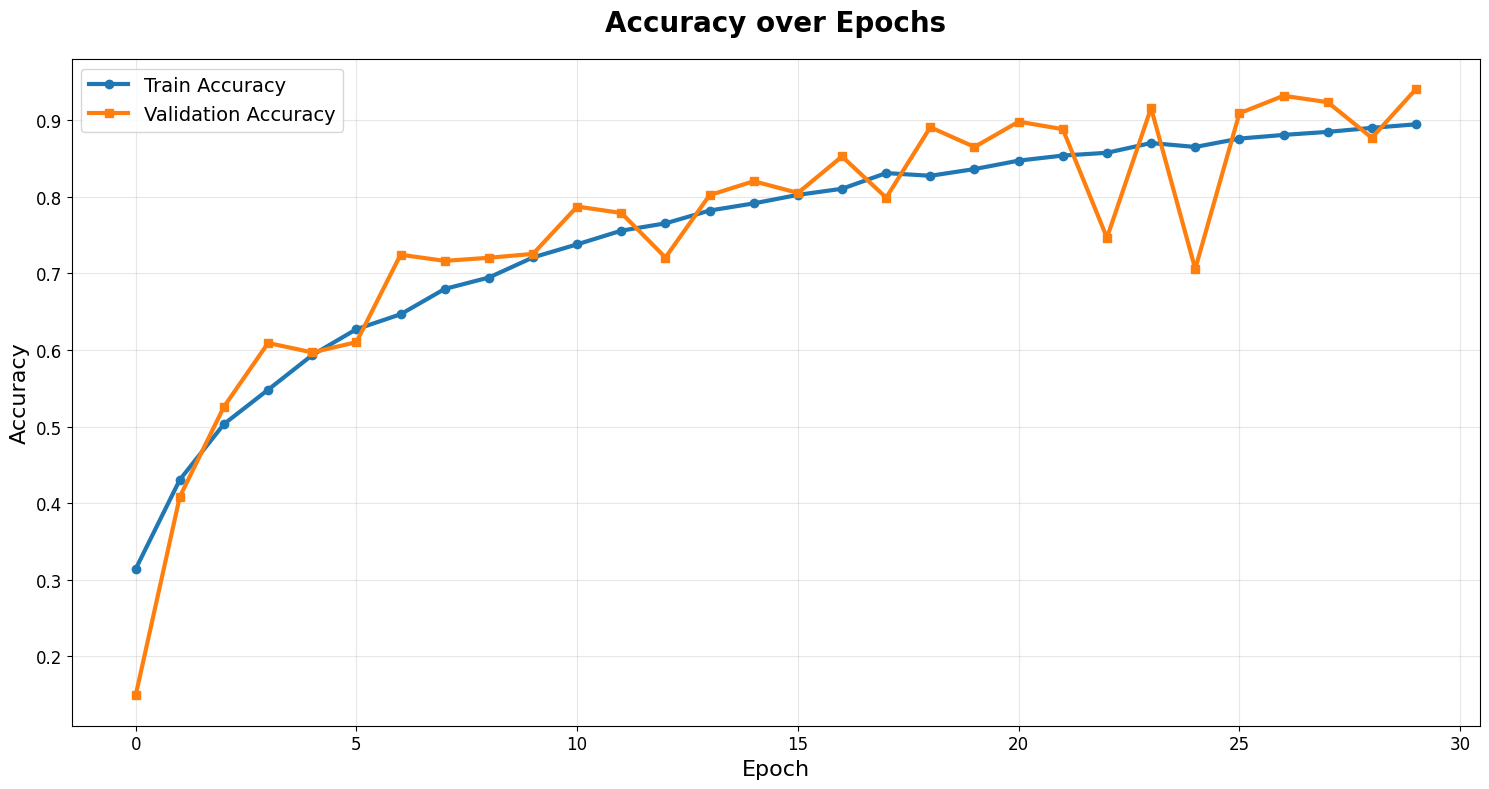

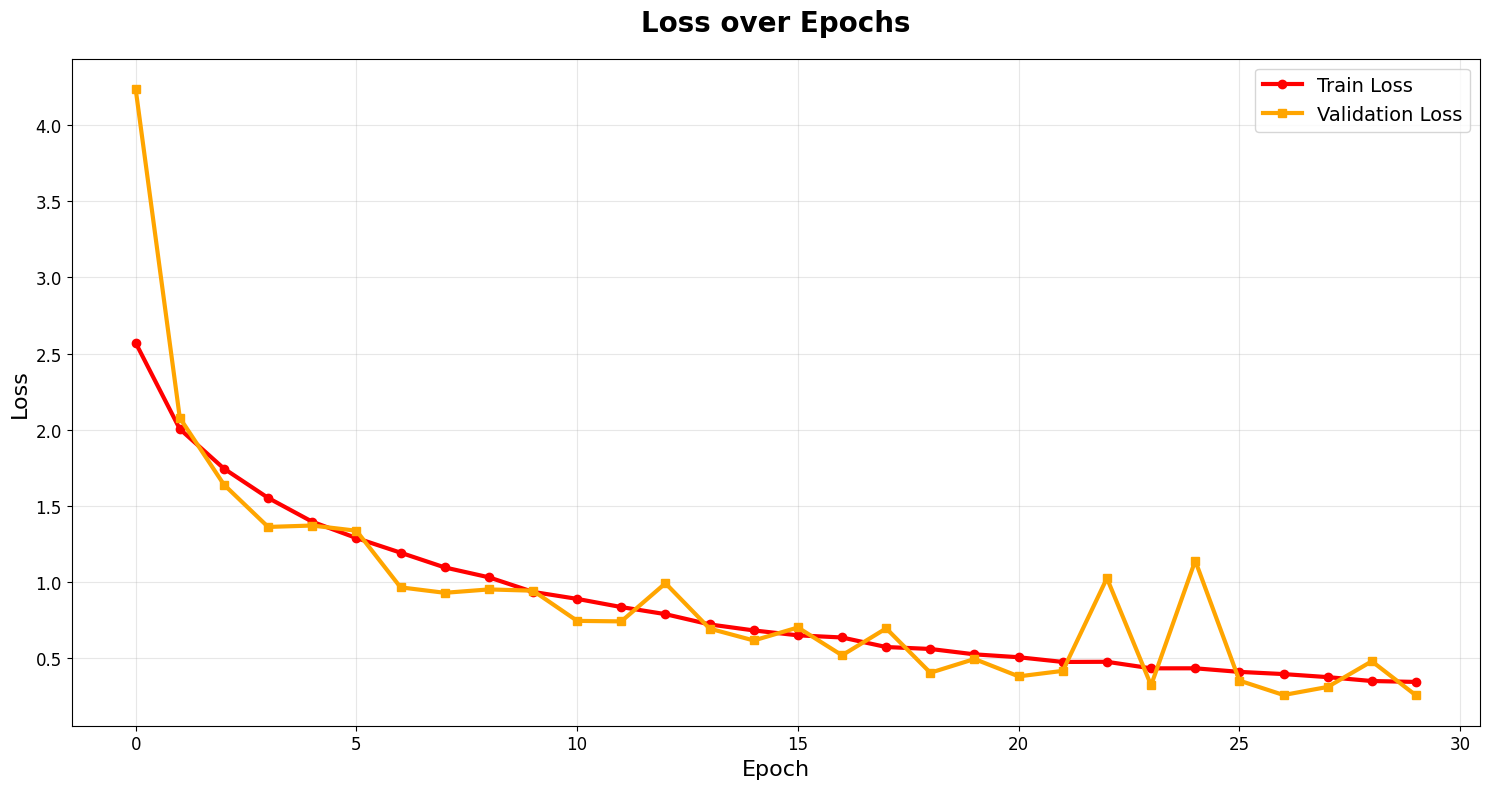

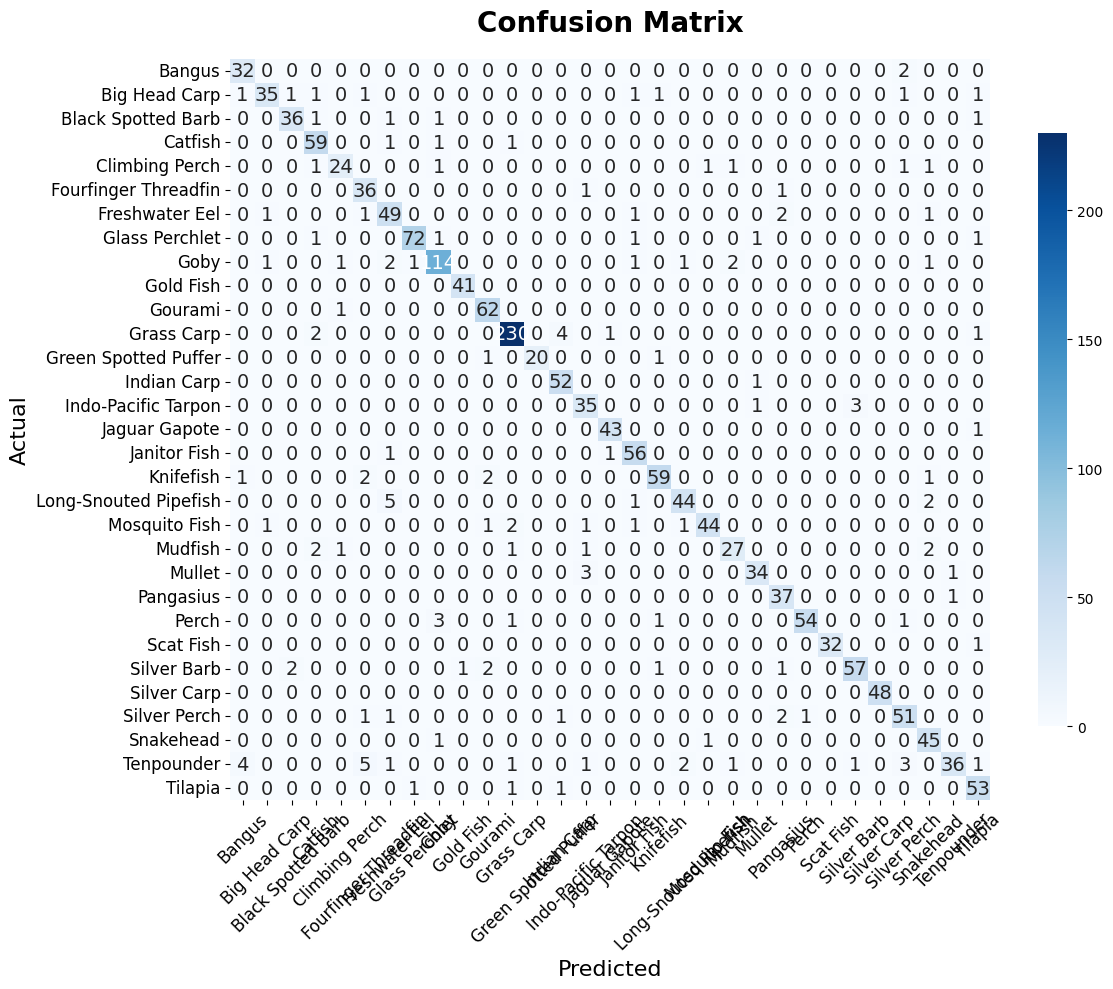

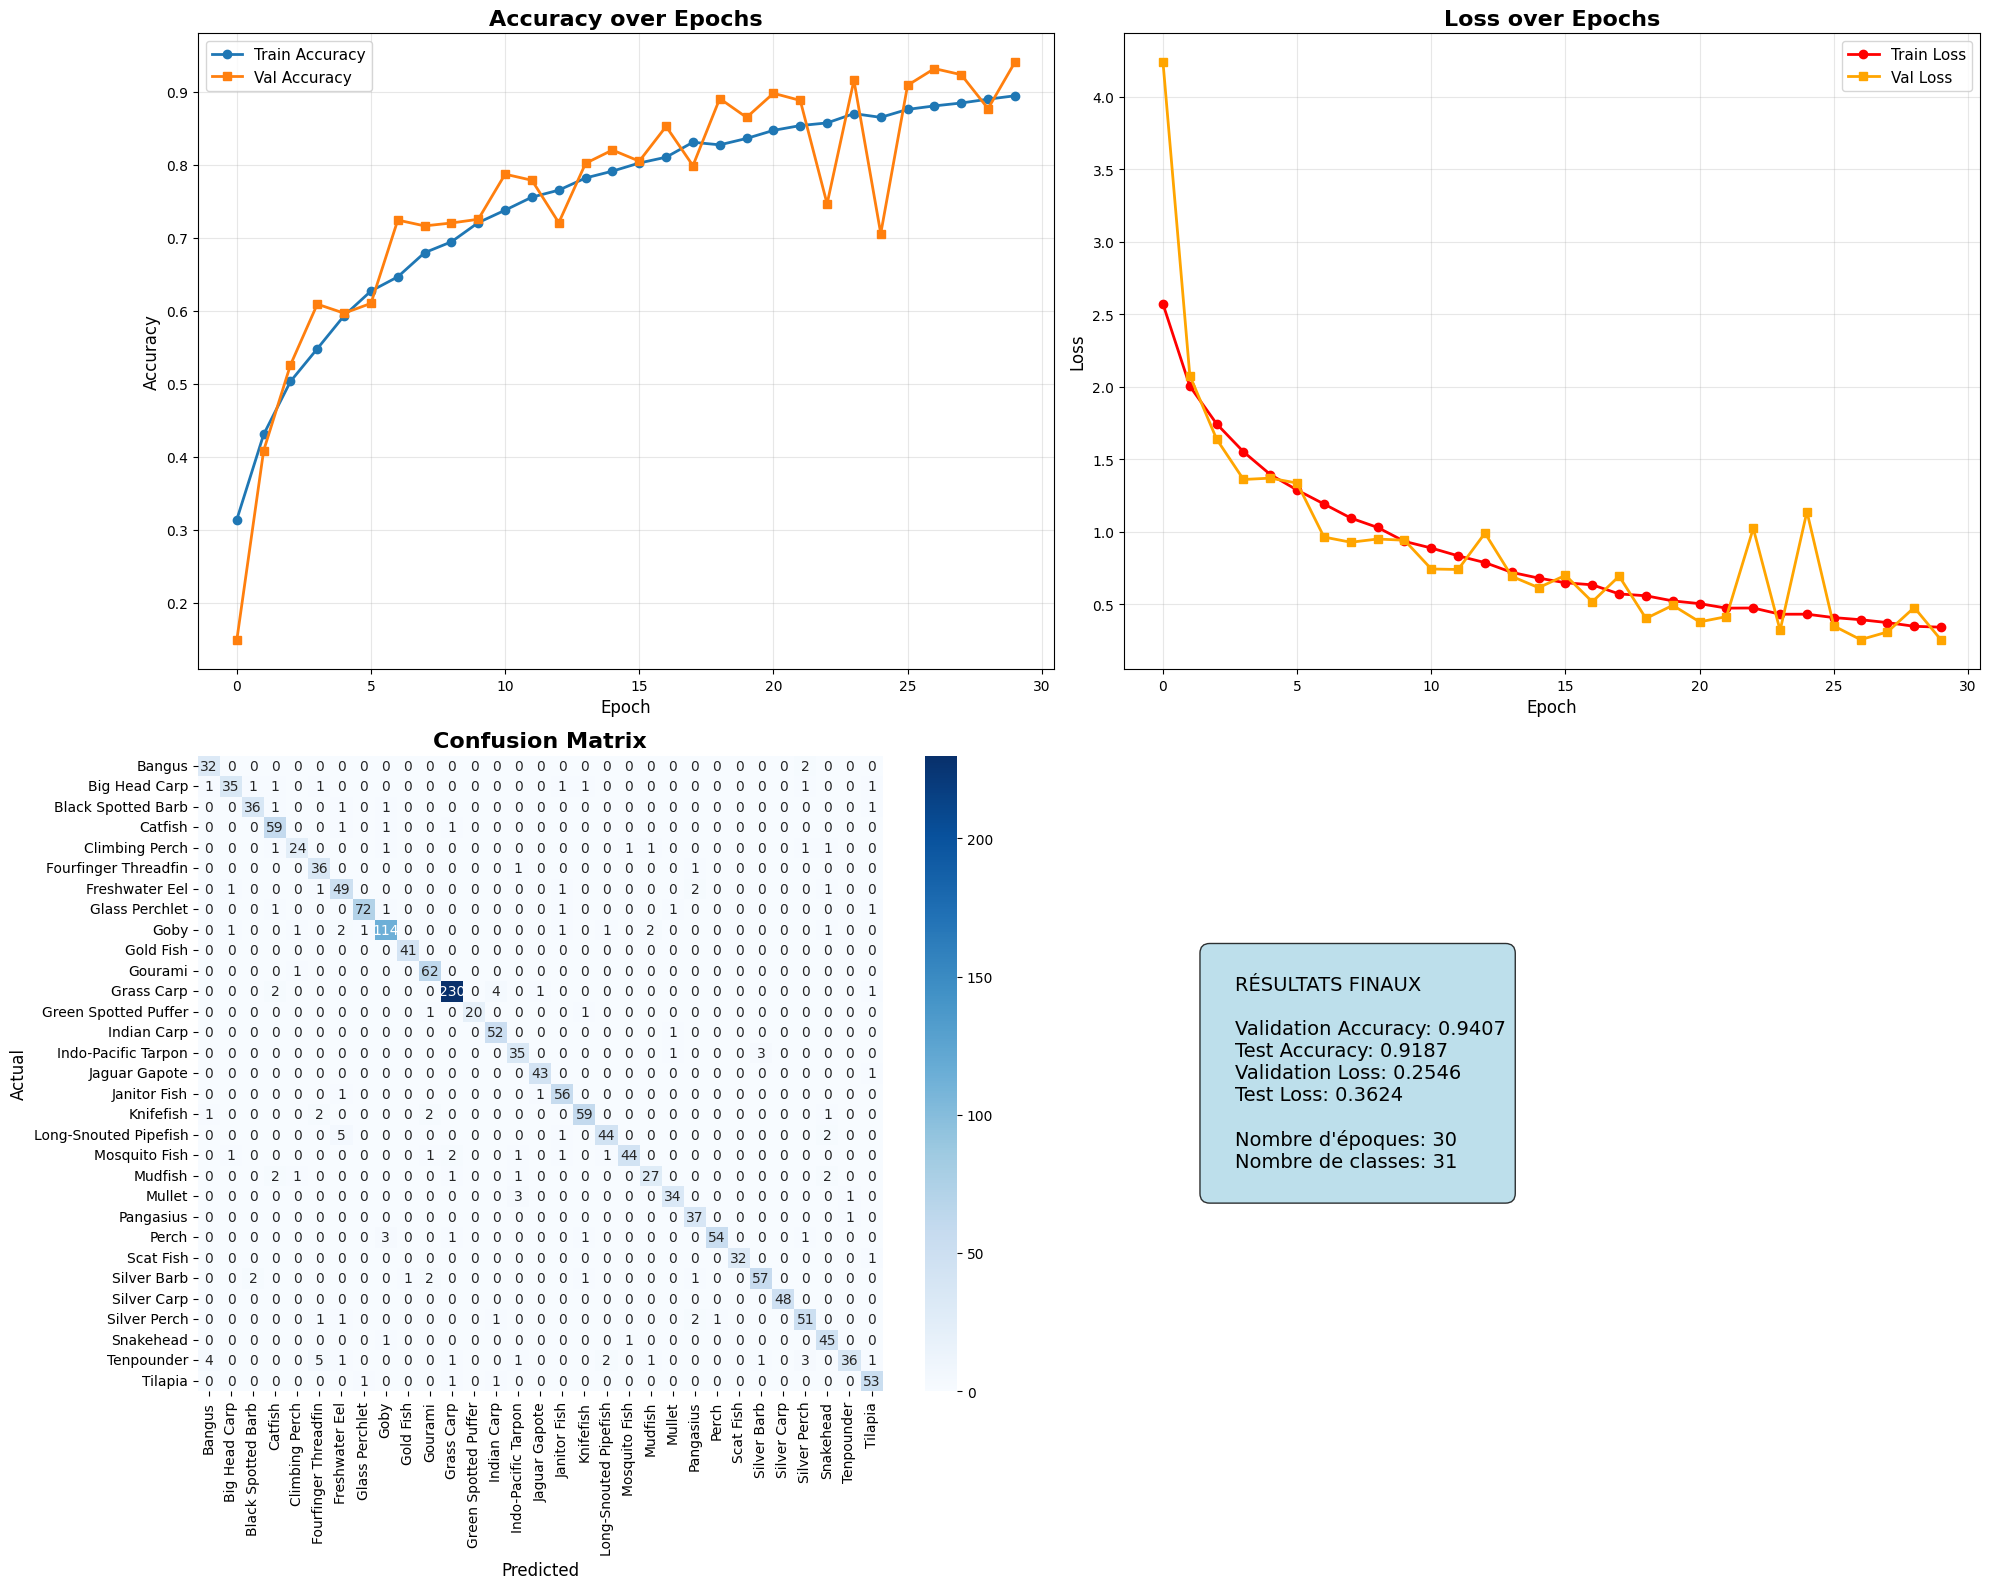


Modèle final enregistré sous le nom 'modele_final.h5'
Accuracy du test final: 0.9187


In [8]:
history, test_acc = train_and_evaluate_model(model, train_generator, val_generator, test_generator, epochs=30)

print(f"Accuracy du test final: {test_acc:.4f}")

In [9]:
model.save('fish_model.keras', save_format='tf')